In [1]:
'''
Final Project - Text Mining on News Articles Retreived from NewsAPI
IST 736 - Text Mining
Spring 2023
'''

# ------------------------------------------- #
# create a fresh file
# no need to run, data file already exists
filename="NewsArticles.csv"
MyFILE=open(filename,"w")  # "a"  for append   "r" for read
## with open
### Place the column names in - write to the first row
WriteThis="LABEL,article\n"
MyFILE.write(WriteThis)
MyFILE.close()

In [2]:
def data_pull(apikey, topic, date_start, date_end):
    import requests
    import re
    filename="NewsArticles.csv"
    MyFILE=open(filename,"a")  # "a"  for append   "r" for read
    ## with open
    ### Place the column names in - write to the first row
    # WriteThis="LABEL,article\n" # only use if new file
    # MyFILE.write(WriteThis)
    MyFILE.close()
    
    # Connect with news-api
    endpoint = "https://newsapi.org/v2/everything"
    
    # pull news data by topic
    URLPost = {'apiKey':apikey, # set api key
                   'q':topic, # specify topic
                   'searchIn':'description', # tell the api to search for topic word in description of article
                   'language':'en', # set langauage of articles to english
                   'from': date_start, # date to start the search in YYYY-MM-DD
                   'to': date_end, # date to end the search in YYYY-MM-DD
                   'sortBy': 'popularity'} # sort by popularity so we get the most meaningful data
    
    response = requests.get(endpoint, URLPost) # use get to curl and return data
    response_json = response.json() # set up response in json format for easy move to csv
    # print(response_json)

    # now publish all articles to a file
    News = open(filename, "a")
    Label = topic
    for article in response_json['articles']:
        # clean up the article
        story = article['content']
        story = str(story)
        story =re.sub(r'[,.;@#?!&$\-\']+', ' ', story, flags=re.IGNORECASE)
        story=re.sub(' +', ' ', story, flags=re.IGNORECASE)
        story=re.sub(r'\"', ' ', story, flags=re.IGNORECASE)
        story=re.sub(r'[^a-zA-Z]', " ", story, flags=re.VERBOSE)
        story=story.replace(',', '')
        story=' '.join(story.split())
        story=re.sub("\n|\r", "", story)

        News.write(str(Label) + ',' + str(story) + '\n')
    News.close()
   

In [1]:
def VectorizeModelCrossVal(dataframe, text_column, label_column, cross_val_folds = 5):
    #Create num_classes variable
    num_classes = len(set(dataframe[label_column]))

    #Create Count, Count Binary, TfIdf, and TfIdf Binary vectors
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
    from sklearn.naive_bayes import MultinomialNB, BernoulliNB
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC, LinearSVC
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cnt = CountVectorizer()
    cnt_bool = CountVectorizer(binary = True)
    tfidf = TfidfVectorizer()
    tfidf_bool = TfidfVectorizer(binary = True)

    #Create dataframe
    data = dataframe[[label_column, text_column]]

    #Make column names uppercase
    text_column = text_column.upper()
    label_column = label_column.upper()
    data.columns = [column.upper() for column in data.columns]

    #Ensure all values are strings
    data[label_column] = [str(row) for row in data[label_column]]
    data[text_column] = [str(row) for row in data[text_column]]

    #Clean data
    #Tokenize words
    import nltk
    data['WORDS'] = [nltk.word_tokenize(doc) for doc in data[text_column]]

    #Clean words - lowercase, remove stopwords, remove phrases with numbers, remove phrases that don't contain letters
    import re
    stopwords = nltk.corpus.stopwords.words('english')
    data['CLEANED_WORDS'] = [[word.lower() for word in doc if word.lower() not in stopwords and not re.match('^.*[0-9]+.*$', word) and re.match('^.*[aA-zZ]+.*$', word)] for doc in data['WORDS']]

    #Stem words with Porter Stemmer
    stemmer = nltk.stem.PorterStemmer()
    data['CLEANED_WORDS'] = [[stemmer.stem(word) for word in doc] for doc in data['CLEANED_WORDS']]

    #Create cleaned review
    data['CLEANED_TEXT'] = [(' '.join(corpus)).strip() for corpus in data['CLEANED_WORDS']]

    #Reorder columns and subset data
    data = data[[label_column, 'CLEANED_TEXT']]

    #Create Vectorized dataframes
    cnt_data = pandas.DataFrame(cnt.fit_transform(data['CLEANED_TEXT']).toarray(), columns = cnt.get_feature_names_out())
    cnt_data = data.join(cnt_data).drop(columns = ['CLEANED_TEXT']).fillna(0)
    cnt_bool_data = pandas.DataFrame(cnt_bool.fit_transform(data['CLEANED_TEXT']).toarray(), columns = cnt_bool.get_feature_names_out())
    cnt_bool_data = data.join(cnt_bool_data).drop(columns = ['CLEANED_TEXT']).fillna(0)
    tfidf_data = pandas.DataFrame(tfidf.fit_transform(data['CLEANED_TEXT']).toarray(), columns = tfidf.get_feature_names_out())
    tfidf_data = data.join(tfidf_data).drop(columns = ['CLEANED_TEXT']).fillna(0)
    tfidf_bool_data = pandas.DataFrame(tfidf_bool.fit_transform(data['CLEANED_TEXT']).toarray(), columns = tfidf_bool.get_feature_names_out())
    tfidf_bool_data = data.join(tfidf_bool_data).drop(columns = ['CLEANED_TEXT']).fillna(0)
    
    #Perform cross validations
    cnt_data = cnt_data.sample(frac = 1)
    cnt_bool_data = cnt_bool_data.sample(frac = 1)
    tfidf_data = tfidf_data.sample(frac = 1)
    tfidf_bool_data = tfidf_bool_data.sample(frac = 1)
    cnt_mnb_acc = []
    cnt_bool_mnb_acc = []
    tfidf_mnb_acc = []
    tfidf_bool_mnb_acc = []
    cnt_bool_ber_acc = []
    tfidf_bool_ber_acc = []
    cnt_dt_acc = []
    cnt_bool_dt_acc = []
    tfidf_dt_acc = []
    tfidf_bool_dt_acc = []
    cnt_rbfsvm_acc = []
    cnt_bool_rbfsvm_acc = []
    tfidf_rbfsvm_acc = []
    tfidf_bool_rbfsvm_acc = []
    cnt_linsvm_acc = []
    cnt_bool_linsvm_acc = []
    tfidf_linsvm_acc = []
    tfidf_bool_linsvm_acc = []
    cnt_polysvm_acc = []
    cnt_bool_polysvm_acc = []
    tfidf_polysvm_acc = []
    tfidf_bool_polysvm_acc = []
    cnt_mnb_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    cnt_bool_mnb_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    tfidf_mnb_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    tfidf_bool_mnb_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    cnt_bool_ber_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    tfidf_bool_ber_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    cnt_dt_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    cnt_bool_dt_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    tfidf_dt_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    tfidf_bool_dt_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    cnt_rbfsvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    cnt_bool_rbfsvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    tfidf_rbfsvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    tfidf_bool_rbfsvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    cnt_linsvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    cnt_bool_linsvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    tfidf_linsvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    tfidf_bool_linsvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    cnt_polysvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    cnt_bool_polysvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    tfidf_polysvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    tfidf_bool_polysvm_cnfmat = [[i*0 for i in range(num_classes)]]*num_classes
    
    for i in range(cross_val_folds):
        
        try:
            #Multinomial Naive Bayes - Count
            test_start = int(len(cnt_data.index)/cross_val_folds) * i
            test_stop = int(len(cnt_data.index)/cross_val_folds) * (i+1)
            test = cnt_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([cnt_data.iloc[:test_start], cnt_data.iloc[test_stop:]])
            mnb = MultinomialNB()
            mnb.fit(train.drop(columns = [label_column]), train[label_column])
            cnt_mnb_acc.append(mnb.score(test, test_labels))
            pred = mnb.predict(test)
            cnt_mnb_cnfmat += confusion_matrix(test_labels, pred)
                
            #Multinomial Naive Bayes - Count Boolean
            test_start = int(len(cnt_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(cnt_bool_data.index)/cross_val_folds) * (i+1)
            test = cnt_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([cnt_bool_data.iloc[:test_start], cnt_bool_data.iloc[test_stop:]])
            mnb = MultinomialNB()
            mnb.fit(train.drop(columns = [label_column]), train[label_column])
            cnt_bool_mnb_acc.append(mnb.score(test, test_labels))
            pred = mnb.predict(test)
            cnt_bool_mnb_cnfmat += confusion_matrix(test_labels, pred)

            #Multinomial Naive Bayes - TfIdf
            test_start = int(len(tfidf_data.index)/cross_val_folds) * i
            test_stop = int(len(tfidf_data.index)/cross_val_folds) * (i+1)
            test = tfidf_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([tfidf_data.iloc[:test_start], tfidf_data.iloc[test_stop:]])
            mnb = MultinomialNB()
            mnb.fit(train.drop(columns = [label_column]), train[label_column])
            tfidf_mnb_acc.append(mnb.score(test, test_labels))
            pred = mnb.predict(test)
            tfidf_mnb_cnfmat += confusion_matrix(test_labels, pred)

            #Multinomial Naive Bayes - TfIdf Boolean
            test_start = int(len(tfidf_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(tfidf_bool_data.index)/cross_val_folds) * (i+1)
            test = tfidf_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([tfidf_bool_data.iloc[:test_start], tfidf_bool_data.iloc[test_stop:]])
            mnb = MultinomialNB()
            mnb.fit(train.drop(columns = [label_column]), train[label_column])
            tfidf_bool_mnb_acc.append(mnb.score(test, test_labels))
            pred = mnb.predict(test)
            tfidf_bool_mnb_cnfmat += confusion_matrix(test_labels, pred)

            #Bernoulli Naive Bayes - Count Boolean
            test_start = int(len(cnt_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(cnt_bool_data.index)/cross_val_folds) * (i+1)
            test = cnt_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([cnt_bool_data.iloc[:test_start], cnt_bool_data.iloc[test_stop:]])
            ber = BernoulliNB()
            ber.fit(train.drop(columns = [label_column]), train[label_column])
            cnt_bool_ber_acc.append(ber.score(test, test_labels))
            pred = ber.predict(test)
            cnt_bool_ber_cnfmat += confusion_matrix(test_labels, pred)

            #Bernoulli Naive Bayes - TfIdf Boolean
            test_start = int(len(tfidf_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(tfidf_bool_data.index)/cross_val_folds) * (i+1)
            test = tfidf_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([tfidf_bool_data.iloc[:test_start], tfidf_bool_data.iloc[test_stop:]])
            ber = BernoulliNB()
            ber.fit(train.drop(columns = [label_column]), train[label_column])
            tfidf_bool_ber_acc.append(ber.score(test, test_labels))
            pred = ber.predict(test)
            tfidf_bool_ber_cnfmat += confusion_matrix(test_labels, pred)

            #Decision Tree - Count
            test_start = int(len(cnt_data.index)/cross_val_folds) * i
            test_stop = int(len(cnt_data.index)/cross_val_folds) * (i+1)
            test = cnt_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([cnt_data.iloc[:test_start], cnt_data.iloc[test_stop:]])
            dt = DecisionTreeClassifier()
            dt.fit(train.drop(columns = [label_column]), train[label_column])
            cnt_dt_acc.append(dt.score(test, test_labels))
            pred = dt.predict(test)
            cnt_dt_cnfmat += confusion_matrix(test_labels, pred)
                
            #Decision Tree - Count Boolean
            test_start = int(len(cnt_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(cnt_bool_data.index)/cross_val_folds) * (i+1)
            test = cnt_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([cnt_bool_data.iloc[:test_start], cnt_bool_data.iloc[test_stop:]])
            dt = DecisionTreeClassifier()
            dt.fit(train.drop(columns = [label_column]), train[label_column])
            cnt_bool_dt_acc.append(dt.score(test, test_labels))
            pred = dt.predict(test)
            cnt_bool_dt_cnfmat += confusion_matrix(test_labels, pred)

            #Decision Tree - TfIdf
            test_start = int(len(tfidf_data.index)/cross_val_folds) * i
            test_stop = int(len(tfidf_data.index)/cross_val_folds) * (i+1)
            test = tfidf_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([tfidf_data.iloc[:test_start], tfidf_data.iloc[test_stop:]])
            dt = DecisionTreeClassifier()
            dt.fit(train.drop(columns = [label_column]), train[label_column])
            tfidf_dt_acc.append(dt.score(test, test_labels))
            pred = dt.predict(test)
            tfidf_dt_cnfmat += confusion_matrix(test_labels, pred)

            #Decision Tree - TfIdf Boolean
            test_start = int(len(tfidf_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(tfidf_bool_data.index)/cross_val_folds) * (i+1)
            test = tfidf_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([tfidf_bool_data.iloc[:test_start], tfidf_bool_data.iloc[test_stop:]])
            dt = DecisionTreeClassifier()
            dt.fit(train.drop(columns = [label_column]), train[label_column])
            tfidf_bool_dt_acc.append(dt.score(test, test_labels))
            pred = dt.predict(test)
            tfidf_bool_dt_cnfmat += confusion_matrix(test_labels, pred)

            #RBF Support Vector Machine - Count
            test_start = int(len(cnt_data.index)/cross_val_folds) * i
            test_stop = int(len(cnt_data.index)/cross_val_folds) * (i+1)
            test = cnt_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([cnt_data.iloc[:test_start], cnt_data.iloc[test_stop:]])
            rbfsvm = SVC()
            rbfsvm.fit(train.drop(columns = [label_column]), train[label_column])
            cnt_rbfsvm_acc.append(rbfsvm.score(test, test_labels))
            pred = rbfsvm.predict(test)
            cnt_rbfsvm_cnfmat += confusion_matrix(test_labels, pred)
                
            #RBF Support Vector Machine - Count Boolean
            test_start = int(len(cnt_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(cnt_bool_data.index)/cross_val_folds) * (i+1)
            test = cnt_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([cnt_bool_data.iloc[:test_start], cnt_bool_data.iloc[test_stop:]])
            rbfsvm = SVC()
            rbfsvm.fit(train.drop(columns = [label_column]), train[label_column])
            cnt_bool_rbfsvm_acc.append(rbfsvm.score(test, test_labels))
            pred = rbfsvm.predict(test)
            cnt_bool_rbfsvm_cnfmat += confusion_matrix(test_labels, pred)

            #RBF Support Vector Machine - TfIdf
            test_start = int(len(tfidf_data.index)/cross_val_folds) * i
            test_stop = int(len(tfidf_data.index)/cross_val_folds) * (i+1)
            test = tfidf_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([tfidf_data.iloc[:test_start], tfidf_data.iloc[test_stop:]])
            rbfsvm = SVC()
            rbfsvm.fit(train.drop(columns = [label_column]), train[label_column])
            tfidf_rbfsvm_acc.append(rbfsvm.score(test, test_labels))
            pred = rbfsvm.predict(test)
            tfidf_rbfsvm_cnfmat += confusion_matrix(test_labels, pred)

            #RBF Support Vector Machine - TfIdf Boolean
            test_start = int(len(tfidf_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(tfidf_bool_data.index)/cross_val_folds) * (i+1)
            test = tfidf_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([tfidf_bool_data.iloc[:test_start], tfidf_bool_data.iloc[test_stop:]])
            rbfsvm = SVC()
            rbfsvm.fit(train.drop(columns = [label_column]), train[label_column])
            tfidf_bool_rbfsvm_acc.append(rbfsvm.score(test, test_labels))
            pred = rbfsvm.predict(test)
            tfidf_bool_rbfsvm_cnfmat += confusion_matrix(test_labels, pred)
            
            #Linear Support Vector Machine - Count
            test_start = int(len(cnt_data.index)/cross_val_folds) * i
            test_stop = int(len(cnt_data.index)/cross_val_folds) * (i+1)
            test = cnt_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([cnt_data.iloc[:test_start], cnt_data.iloc[test_stop:]])
            linsvm = LinearSVC()
            linsvm.fit(train.drop(columns = [label_column]), train[label_column])
            cnt_linsvm_acc.append(linsvm.score(test, test_labels))
            pred = linsvm.predict(test)
            cnt_linsvm_cnfmat += confusion_matrix(test_labels, pred)
                
            #Linear Support Vector Machine - Count Boolean
            test_start = int(len(cnt_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(cnt_bool_data.index)/cross_val_folds) * (i+1)
            test = cnt_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([cnt_bool_data.iloc[:test_start], cnt_bool_data.iloc[test_stop:]])
            linsvm = LinearSVC()
            linsvm.fit(train.drop(columns = [label_column]), train[label_column])
            cnt_bool_linsvm_acc.append(linsvm.score(test, test_labels))
            pred = linsvm.predict(test)
            cnt_bool_linsvm_cnfmat += confusion_matrix(test_labels, pred)

            #Linear Support Vector Machine - TfIdf
            test_start = int(len(tfidf_data.index)/cross_val_folds) * i
            test_stop = int(len(tfidf_data.index)/cross_val_folds) * (i+1)
            test = tfidf_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([tfidf_data.iloc[:test_start], tfidf_data.iloc[test_stop:]])
            linsvm = LinearSVC()
            linsvm.fit(train.drop(columns = [label_column]), train[label_column])
            tfidf_linsvm_acc.append(linsvm.score(test, test_labels))
            pred = linsvm.predict(test)
            tfidf_linsvm_cnfmat += confusion_matrix(test_labels, pred)

            #Linear Support Vector Machine - TfIdf Boolean
            test_start = int(len(tfidf_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(tfidf_bool_data.index)/cross_val_folds) * (i+1)
            test = tfidf_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([tfidf_bool_data.iloc[:test_start], tfidf_bool_data.iloc[test_stop:]])
            linsvm = LinearSVC()
            linsvm.fit(train.drop(columns = [label_column]), train[label_column])
            tfidf_bool_linsvm_acc.append(linsvm.score(test, test_labels))
            pred = linsvm.predict(test)
            tfidf_bool_linsvm_cnfmat += confusion_matrix(test_labels, pred)

            #Polynomial Support Vector Machine - Count
            test_start = int(len(cnt_data.index)/cross_val_folds) * i
            test_stop = int(len(cnt_data.index)/cross_val_folds) * (i+1)
            test = cnt_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([cnt_data.iloc[:test_start], cnt_data.iloc[test_stop:]])
            polysvm = SVC(kernel = 'poly')
            polysvm.fit(train.drop(columns = [label_column]), train[label_column])
            cnt_polysvm_acc.append(polysvm.score(test, test_labels))
            pred = polysvm.predict(test)
            cnt_polysvm_cnfmat += confusion_matrix(test_labels, pred)
                
            #Polynomial Support Vector Machine - Count Boolean
            test_start = int(len(cnt_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(cnt_bool_data.index)/cross_val_folds) * (i+1)
            test = cnt_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([cnt_bool_data.iloc[:test_start], cnt_bool_data.iloc[test_stop:]])
            polysvm = SVC(kernel = 'poly')
            polysvm.fit(train.drop(columns = [label_column]), train[label_column])
            cnt_bool_polysvm_acc.append(polysvm.score(test, test_labels))
            pred = polysvm.predict(test)
            cnt_bool_polysvm_cnfmat += confusion_matrix(test_labels, pred)

            #Polynomial Support Vector Machine - TfIdf
            test_start = int(len(tfidf_data.index)/cross_val_folds) * i
            test_stop = int(len(tfidf_data.index)/cross_val_folds) * (i+1)
            test = tfidf_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([tfidf_data.iloc[:test_start], tfidf_data.iloc[test_stop:]])
            polysvm = SVC(kernel = 'poly')
            polysvm.fit(train.drop(columns = [label_column]), train[label_column])
            tfidf_polysvm_acc.append(polysvm.score(test, test_labels))
            pred = polysvm.predict(test)
            tfidf_polysvm_cnfmat += confusion_matrix(test_labels, pred)

            #Polynomial Support Vector Machine - TfIdf Boolean
            test_start = int(len(tfidf_bool_data.index)/cross_val_folds) * i
            test_stop = int(len(tfidf_bool_data.index)/cross_val_folds) * (i+1)
            test = tfidf_bool_data.iloc[test_start : test_stop]
            test_labels = test[label_column]
            test = test.drop(columns = [label_column])
            train = pandas.concat([tfidf_bool_data.iloc[:test_start], tfidf_bool_data.iloc[test_stop:]])
            polysvm = SVC(kernel = 'poly')
            polysvm.fit(train.drop(columns = [label_column]), train[label_column])
            tfidf_bool_polysvm_acc.append(polysvm.score(test, test_labels))
            pred = polysvm.predict(test)
            tfidf_bool_polysvm_cnfmat += confusion_matrix(test_labels, pred)

        #Pass if fails
        except: pass

    #Create accuracy dataframe
    model_list = ['Multinomial Naive Bayes']*12 + ['Bernoulli Naive Bayes']*6 + ['Decision Tree']*12 + ['Support Vector Machine (RBF Kernel)']*12 \
                        + ['Support Vector Machine (Linear Kernel)']*12 + ['Support Vector Machine (Polynomial Kernel)']*12
    vectorizer_list = ['Count']*3 + ['Boolean Count']*3 + ['TfIdf']*3 + ['Boolean TfIdf']*3 + ['Boolean Count']*3 + ['Boolean TfIdf']*3 + ['Count']*3 + ['Boolean Count']*3 + ['TfIdf']*3 + ['Boolean TfIdf']*3 \
                        + ['Count']*3 + ['Boolean Count']*3 + ['TfIdf']*3 + ['Boolean TfIdf']*3 + ['Count']*3 + ['Boolean Count']*3 + ['TfIdf']*3 + ['Boolean TfIdf']*3 \
                        + ['Count']*3 + ['Boolean Count']*3 + ['TfIdf']*3 + ['Boolean TfIdf']*3
    measure_list = ['Average Accuracy', 'Minimum Accuracy', 'Maximum Accuracy']*22
    value_list = [sum(cnt_mnb_acc) / cross_val_folds, min(cnt_mnb_acc), max(cnt_mnb_acc),
                    sum(cnt_bool_mnb_acc) / cross_val_folds, min(cnt_bool_mnb_acc), max(cnt_bool_mnb_acc),
                    sum(tfidf_mnb_acc) / cross_val_folds, min(tfidf_mnb_acc), max(tfidf_mnb_acc),
                    sum(tfidf_bool_mnb_acc) / cross_val_folds, min(tfidf_bool_mnb_acc), max(tfidf_bool_mnb_acc),
                    sum(cnt_bool_ber_acc) / cross_val_folds, min(cnt_bool_ber_acc), max(cnt_bool_ber_acc),
                    sum(tfidf_bool_ber_acc) / cross_val_folds, min(tfidf_bool_ber_acc), max(tfidf_bool_ber_acc),
                    sum(cnt_dt_acc) / cross_val_folds, min(cnt_dt_acc), max(cnt_dt_acc),
                    sum(cnt_bool_dt_acc) / cross_val_folds, min(cnt_bool_dt_acc), max(cnt_bool_dt_acc),
                    sum(tfidf_dt_acc) / cross_val_folds, min(tfidf_dt_acc), max(tfidf_dt_acc),
                    sum(tfidf_bool_dt_acc) / cross_val_folds, min(tfidf_bool_dt_acc), max(tfidf_bool_dt_acc),
                    sum(cnt_rbfsvm_acc) / cross_val_folds, min(cnt_rbfsvm_acc), max(cnt_rbfsvm_acc),
                    sum(cnt_bool_rbfsvm_acc) / cross_val_folds, min(cnt_bool_rbfsvm_acc), max(cnt_bool_rbfsvm_acc),
                    sum(tfidf_rbfsvm_acc) / cross_val_folds, min(tfidf_rbfsvm_acc), max(tfidf_rbfsvm_acc),
                    sum(tfidf_bool_rbfsvm_acc) / cross_val_folds, min(tfidf_bool_rbfsvm_acc), max(tfidf_bool_rbfsvm_acc),
                    sum(cnt_linsvm_acc) / cross_val_folds, min(cnt_linsvm_acc), max(cnt_linsvm_acc),
                    sum(cnt_bool_linsvm_acc) / cross_val_folds, min(cnt_bool_linsvm_acc), max(cnt_bool_linsvm_acc),
                    sum(tfidf_linsvm_acc) / cross_val_folds, min(tfidf_linsvm_acc), max(tfidf_linsvm_acc),
                    sum(tfidf_bool_linsvm_acc) / cross_val_folds, min(tfidf_bool_linsvm_acc), max(tfidf_bool_linsvm_acc),
                    sum(cnt_polysvm_acc) / cross_val_folds, min(cnt_polysvm_acc), max(cnt_polysvm_acc),
                    sum(cnt_bool_polysvm_acc) / cross_val_folds, min(cnt_bool_polysvm_acc), max(cnt_bool_polysvm_acc),
                    sum(tfidf_polysvm_acc) / cross_val_folds, min(tfidf_polysvm_acc), max(tfidf_polysvm_acc),
                    sum(tfidf_bool_polysvm_acc) / cross_val_folds, min(tfidf_bool_polysvm_acc), max(tfidf_bool_polysvm_acc)]
    data_list = [[model_list[i], vectorizer_list[i], measure_list[i], value_list[i]] for i in range(66)]
    acc_df = pandas.DataFrame(data_list, columns = ['Model', 'Vectorizer', 'Measure', 'Value'])

    print('--------------ACCURACY SUMMARY---------------')
    print()
    print('Multinomial Naive Bayes with Count Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(cnt_mnb_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(cnt_mnb_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(cnt_mnb_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(cnt_mnb_cnfmat)
    print()
    print('Multinomial Naive Bayes with Boolean Count Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(cnt_bool_mnb_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(cnt_bool_mnb_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(cnt_bool_mnb_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(cnt_bool_mnb_cnfmat)
    print()
    print('Multinomial Naive Bayes with TfIdf Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(tfidf_mnb_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(tfidf_mnb_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(tfidf_mnb_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(tfidf_mnb_cnfmat)
    print()
    print('Multinomial Naive Bayes with Boolean TfIdf Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(tfidf_bool_mnb_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(tfidf_bool_mnb_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(tfidf_bool_mnb_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(tfidf_bool_mnb_cnfmat)
    print()
    print('Bernoulli Naive Bayes with Boolean Count Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(cnt_bool_ber_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(cnt_bool_ber_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(cnt_bool_ber_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(cnt_bool_ber_cnfmat)
    print()
    print('Bernoulli Naive Bayes with Boolean TfIdf Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(tfidf_bool_ber_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(tfidf_bool_ber_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(tfidf_bool_ber_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(tfidf_bool_ber_cnfmat)
    print()
    print('Decision Tree with Count Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(cnt_dt_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(cnt_dt_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(cnt_dt_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(cnt_dt_cnfmat)
    print()
    print('Decision Tree with Boolean Count Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(cnt_bool_dt_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(cnt_bool_dt_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(cnt_bool_dt_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(cnt_bool_dt_cnfmat)
    print()
    print('Decision Tree with TfIdf Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(tfidf_dt_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(tfidf_dt_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(tfidf_dt_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(tfidf_dt_cnfmat)
    print()
    print('Decision Tree with Boolean TfIdf Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(tfidf_bool_dt_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(tfidf_bool_dt_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(tfidf_bool_dt_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(tfidf_bool_dt_cnfmat)
    print()
    print('Support Vector Machine (RBF Kernel) with Count Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(cnt_rbfsvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(cnt_rbfsvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(cnt_rbfsvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(cnt_rbfsvm_cnfmat)
    print()
    print('Support Vector Machine (RBF Kernel) with Boolean Count Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(cnt_bool_rbfsvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(cnt_bool_rbfsvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(cnt_bool_rbfsvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(cnt_bool_rbfsvm_cnfmat)
    print()
    print('Support Vector Machine (RBF Kernel) with TfIdf Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(tfidf_rbfsvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(tfidf_rbfsvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(tfidf_rbfsvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(tfidf_rbfsvm_cnfmat)
    print()
    print('Support Vector Machine (RBF Kernel) with Boolean TfIdf Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(tfidf_bool_rbfsvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(tfidf_bool_rbfsvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(tfidf_bool_rbfsvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(tfidf_bool_rbfsvm_cnfmat)
    print()
    print('Support Vector Machine (Linear Kernel) with Count Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(cnt_linsvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(cnt_linsvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(cnt_linsvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(cnt_linsvm_cnfmat)
    print()
    print('Support Vector Machine (Linear Kernel) with Boolean Count Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(cnt_bool_linsvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(cnt_bool_linsvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(cnt_bool_linsvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(cnt_bool_linsvm_cnfmat)
    print()
    print('Support Vector Machine (Linear Kernel) with TfIdf Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(tfidf_linsvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(tfidf_linsvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(tfidf_linsvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(tfidf_linsvm_cnfmat)
    print()
    print('Support Vector Machine (Linear Kernel) with Boolean TfIdf Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(tfidf_bool_linsvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(tfidf_bool_linsvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(tfidf_bool_linsvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(tfidf_bool_linsvm_cnfmat)
    print()
    print('Support Vector Machine (Polynomial Kernel) with Count Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(cnt_polysvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(cnt_polysvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(cnt_polysvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(cnt_polysvm_cnfmat)
    print()
    print('Support Vector Machine (Polynomial Kernel) with Boolean Count Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(cnt_bool_polysvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(cnt_bool_polysvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(cnt_bool_polysvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(cnt_bool_polysvm_cnfmat)
    print()
    print('Support Vector Machine (Polynomial Kernel) with TfIdf Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(tfidf_polysvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(tfidf_polysvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(tfidf_polysvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(tfidf_polysvm_cnfmat)
    print()
    print('Support Vector Machine (Polynomial Kernel) with Boolean TfIdf Vectorization -', cross_val_folds, 'FOLD CROSS VALIDATION')
    print('Average Accuracy:', round((sum(tfidf_bool_polysvm_acc) / cross_val_folds)*100, 2), '%')
    print('Minimum Accuracy:', round(min(tfidf_bool_polysvm_acc)*100, 2), '%')
    print('Maximum Accuracy:', round(max(tfidf_bool_polysvm_acc)*100, 2), '%')
    print('Confusion Matrix for Folds Where All', num_classes, 'Classifications are Represented:')
    print(tfidf_bool_polysvm_cnfmat)
    print()
    print()
    print('ACCURACY DATAFRAME')
    print(acc_df)
    print()
    print('BEST MODEL(S) (Average Accuracy)')
    print(acc_df[acc_df['Value'] == max(acc_df[acc_df['Measure'] == 'Average Accuracy']['Value'])])



In [2]:
def VectorizeLDA(dataframe, text_column, n_grams = 1, tfidf = False, boolean = False, vec_in_title = False, title = 'LDA Model Topics', LDA_topics = 5, top_words = 15):

    #Create Count, Count Binary, TfIdf, and TfIdf Binary vectors
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
    if (not tfidf) & (not boolean): vec = CountVectorizer(ngram_range = (n_grams, n_grams))
    if (not tfidf) & (boolean): vec = CountVectorizer(binary = True, ngram_range = (n_grams, n_grams))
    if (tfidf) & (not boolean): vec = TfidfVectorizer(ngram_range = (n_grams, n_grams))
    if (tfidf) & (boolean): vec = TfidfVectorizer(binary = True, ngram_range = (n_grams, n_grams))

    #Create dataframe
    data = dataframe[[text_column]]
    
    #Ensure all values are strings
    data['text'] = [str(row) for row in data[text_column]]

    #Clean data
    #Tokenize words
    import nltk
    data['WORDS'] = [nltk.word_tokenize(doc) for doc in data['text']]

    #Clean words - lowercase, remove stopwords, remove phrases with numbers, remove phrases that don't contain letters
    import re
    stopwords = nltk.corpus.stopwords.words('english')
    data['CLEANED_WORDS'] = [[word.lower() for word in doc if word.lower() not in stopwords and not re.match('^.*[0-9]+.*$', word) and re.match('^.*[aA-zZ]+.*$', word)] for doc in data['WORDS']]
    #Stem words with Porter Stemmer
    stemmer = nltk.stem.PorterStemmer()
    data['CLEANED_WORDS'] = [[stemmer.stem(word) for word in doc] for doc in data['CLEANED_WORDS']]

    #Remove "char"
    data['CLEANED_WORDS'] = [[word for word in doc if word != 'char'] for doc in data['CLEANED_WORDS']]

    #Create cleaned review
    data['CLEANED_TEXT'] = [(' '.join(corpus)).strip() for corpus in data['CLEANED_WORDS']]

    #Reorder columns and subset data
    data = data['CLEANED_TEXT']

    #Create Vectorized dataframes
    print('CREATING VECTORIZED DATAFRAME...')
    vec_data = pandas.DataFrame(vec.fit_transform(data).toarray(), columns = vec.get_feature_names_out())
    print('VECTORIZED DATAFRAME CREATED SUCCESSFULLY.')
    print()

    #Create LDA Models
    from sklearn.decomposition import LatentDirichletAllocation

    print('TRAINING LATENT DIRICHLET ALLOCATION MODEL...')
    lda_model = LatentDirichletAllocation(n_components = LDA_topics)
    lda_model.fit_transform(vec_data)
    print('MODEL TRAINED SUCCESSFULLY.')
    print()

    #VISUALIZATION
    from matplotlib import pyplot
    import numpy

    word_topic = numpy.array(lda_model.components_).transpose()
    num_top_words = top_words
    num_topics = LDA_topics
    vocab = numpy.asarray(vec_data.columns)
    fontsize_base = 20
    for i in range(num_topics):
        pyplot.subplot(1, num_topics, i + 1)
        pyplot.ylim(0, num_top_words + 0.5)
        pyplot.xticks([])
        pyplot.yticks([])
        pyplot.axis('off')
        pyplot.title('Topic #{}'.format(i+1))
        top_words_idx = numpy.argsort(word_topic[:,i])[::-1]
        top_words_idx = top_words_idx[:num_top_words]
        top_words = vocab[top_words_idx]
        top_words_shares = word_topic[top_words_idx, i]
        for j, (word, share) in enumerate(zip(top_words, top_words_shares)):
            pyplot.text(0.3, num_top_words-j-0.5, word, fontsize=fontsize_base)
    
    if vec_in_title:
        if (not tfidf) & (not boolean): vec_title = ' (Count Vectorizer)'
        if (not tfidf) & (boolean): vec_title = ' (Count Boolean Vectorizer)'
        if (tfidf) & (not boolean): vec_title = ' (Tfidf Vectorizer)'
        if (tfidf) & (boolean): vec_title = ' (Tfidf Boolean Vectorizer)'
    else: vec_title = ''

    pyplot.suptitle(title + vec_title)
    pyplot.tight_layout()
    print('DISPLAYING VISUAL. THIS MAY BE IN A SEPARATE WINDOW.')
    print('IF THIS IS IN A SEPARATE WINDOW, CLOSE THE WINDOW TO PROCEED.')
    pyplot.show()
    print('\n\n')

In [3]:

#API Keys
Nicks_Key = '0a1ccb2c1330478d82d98f40f7833706'
# Adriannes_Key = ''
# Brians_Key = ''
Andrews_Key = '2251c3746949451db819cd694fcb09b2'

#Loop through API Keys to pull data
keylist = [Nicks_Key, Andrews_Key]
# for key in keylist: data_pull(key, topic = 'politics', date_start = '2023-05-04', date_end = '2023-05-06')
# pulled data from 2023-05-04 to 2023-06-04

In [4]:
import datetime
def wayback(x):
    days_back = 30
    while days_back >=1 :
        start = (datetime.datetime.now() - datetime.timedelta(days=days_back)).strftime('%Y-%m-%d')
        # start time is 28 days in the past. strftime converts to the correct YYY-MM-DD format for the api
        end = start # only want to pull topics for that day
        for key in keylist: data_pull(key, topic = x, 
                                      date_start = start, date_end = end)
        days_back-=1 # decrement by 1

In [5]:
# after this is done, open up the csv and remove the weird cookies sentences.
# also removed blank rows
# ------------------------------------------- #
# topics
#politic = wayback('politics')
#sport = wayback('sports')
#climate = wayback('climate')
#health = wayback('health') # run this and the remainder
#weather = wayback('weather')

#Create dataframe
import pandas
# from random import sample
data = pandas.read_csv('NewsArticles.csv')
data['article'] = [str(row) for row in data['article']] #convert articles to strings if they aren't already
data['LABEL'] = [str(row) for row in data['LABEL']] #convert labels to strings if they aren't already
data_sample = data.sample(frac=0.05) # take a sample of the data

In [6]:
data_sample

,LABEL,article
3437,politics,I could hardly believe this ad in the New York...
4846,politics,Let s go for my web review for the week Japan ...
19305,weather,Google Maps will soon be making its Immersive ...
24018,weather,Geneva AFP Celeste Saulo the incoming head of ...
7552,sports,David Chapman is CEO of Marketing a national c...
...,...,...
9969,sports,PITTSBURGH AP Former Pittsburgh Steelers and N...
18279,health,The Senate President Ahmad Lawan has commissio...
18275,health,By Michael Nevradakis Ph D The Defender The Wo...
5052,politics,Heres how in its lead story Thursday The New Y...


politics
weather
sports
climate
health


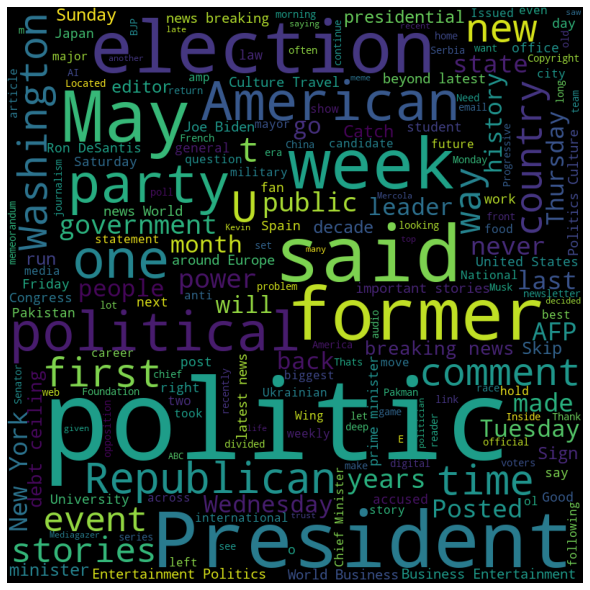

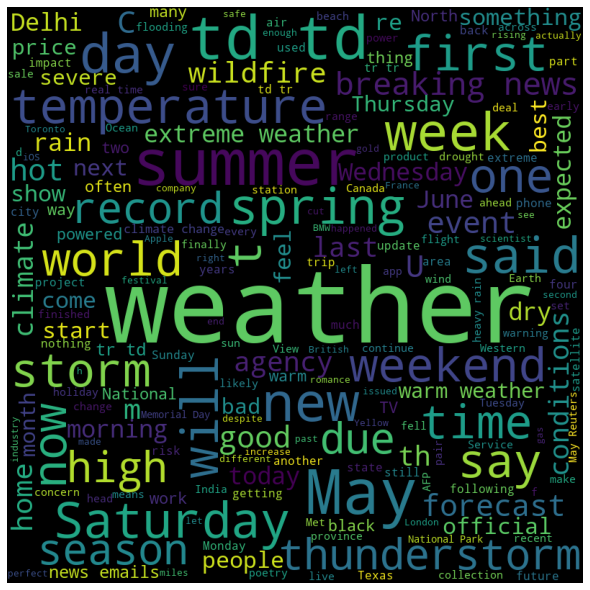

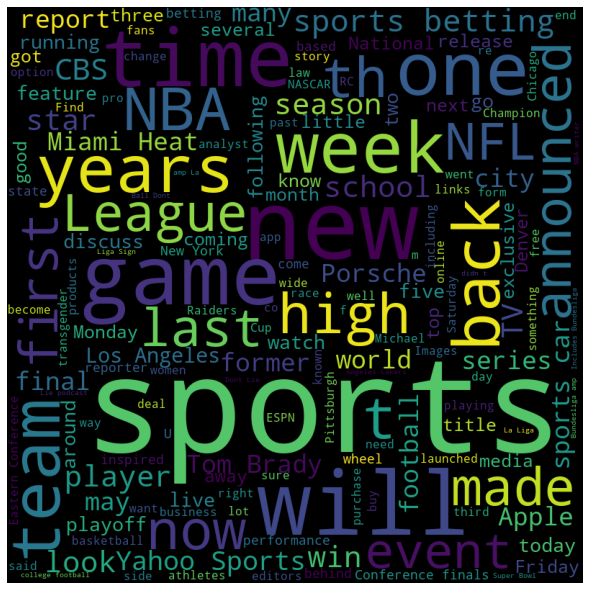

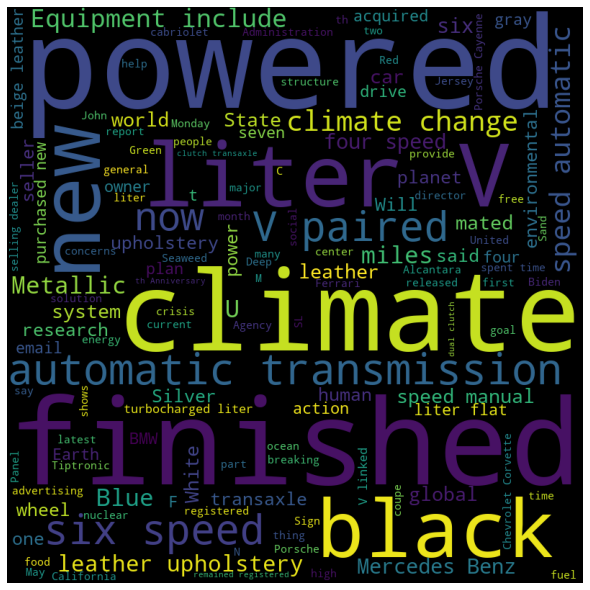

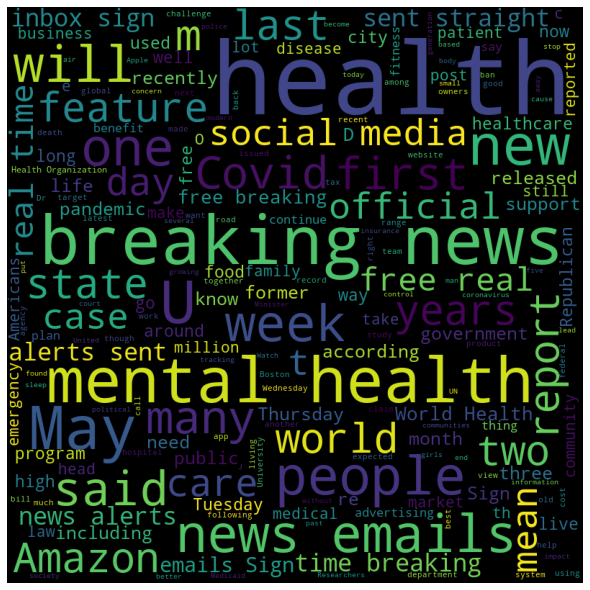

In [7]:
# ------------------------------------------- #
## Wordclouds
# random words that show up and make data unclean
# import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
extra_words = ['ul','li','cookies','services','statistics','chars','science','space','technology',
                'data','site','use','data','Google','Track','Measure','audience','Track','Getty',
                'Deliver','outages','engagement','spam','protect','abuse','fraud','maintain','year','s','unde']

# For loop to print out wordclouds for each topic
for topic in data_sample['LABEL'].unique():
    
    cloud_box = []
    for x in range(len(data_sample)):
        label = data_sample.iloc[x,0]
        article = data_sample.iloc[x,1]
        if label == topic:
            cloud_box.append(article)
    #         cloud_box.append(item)
    # generate topics of articles word clouds
    wordcloud = WordCloud(width = 800, 
                    height = 800,
                    stopwords = list(STOPWORDS) + extra_words,
                    background_color ='black',
                    min_font_size = 10).generate((' ').join(cloud_box))
    print(topic)
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None, )
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)


--------------ACCURACY SUMMARY---------------

Multinomial Naive Bayes with Count Vectorization - 10 FOLD CROSS VALIDATION
Average Accuracy: 26.21 %
Minimum Accuracy: 20.16 %
Maximum Accuracy: 31.45 %
Confusion Matrix for Folds Where All 5 Classifications are Represented:
[[  0  11   0  79   9]
 [  0  20   0 239  27]
 [  0  17  56 168  26]
 [  0  38   0 227  35]
 [  0  33   0 233  22]]

Multinomial Naive Bayes with Boolean Count Vectorization - 10 FOLD CROSS VALIDATION
Average Accuracy: 24.92 %
Minimum Accuracy: 19.35 %
Maximum Accuracy: 33.06 %
Confusion Matrix for Folds Where All 5 Classifications are Represented:
[[  0  11   0  69  19]
 [  0  20   0 204  60]
 [  0  21  56 149  42]
 [  0  37   0 189  74]
 [  0  30   0 215  44]]

Multinomial Naive Bayes with TfIdf Vectorization - 10 FOLD CROSS VALIDATION
Average Accuracy: 26.53 %
Minimum Accuracy: 20.97 %
Maximum Accuracy: 32.26 %
Confusion Matrix for Folds Where All 5 Classifications are Represented:
[[  0   0   0  93   5]
 [  0   0 

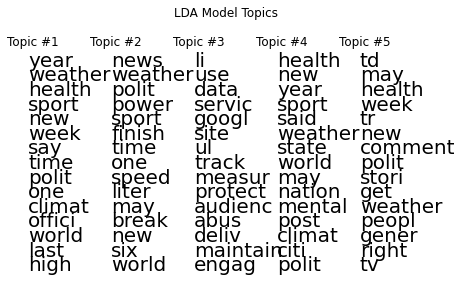

In [8]:
#Run Models
VectorizeModelCrossVal(data_sample, text_column = 'article', label_column = 'LABEL', cross_val_folds = 10)
VectorizeLDA(data_sample, text_column = 'article')


In [9]:
# Change data type of articles text from object to string
data_sample['article'] = data_sample['article'].astype("string")

# Confirm data type change of articles column
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1243 entries, 3437 to 6794
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   LABEL    1243 non-null   object
 1   article  1243 non-null   string
dtypes: object(1), string(1)
memory usage: 61.4+ KB


In [10]:
## Process and clean-up article column of sample data

# Lower case the text 
data_sample['clean_article'] = data_sample['article'].apply(lambda x: x.lower())

# Change data type of articles text from object to string
data_sample['clean_article'] = data_sample['clean_article'].astype("string")

#Tokenize words
import nltk
data_sample['clean_article'] = data_sample['clean_article'].apply(lambda x: nltk.word_tokenize(x))

# Remove stop words 
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Remove other stop words and add to current stop words list
new_stop = ['chars', 'with', 'this', 'unde','have', 'first','said','three','daily','will', 'that', 'politics','sports','weather','climate','health', 'also']
stop.extend(new_stop)
data_sample['clean_article'] = data_sample['clean_article'].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))

# Remove words that are 3 characters and less
data_sample['clean_article'] = data_sample['clean_article'].str.replace(r'\b(\w{1,3})\b', '')
                            

In [11]:
# Validate clean article column in sample data frame
data_sample

,LABEL,article,clean_article
3437,politics,I could hardly believe this ad in the New York...,could hardly believe ad new york times last fr...
4846,politics,Let s go for my web review for the week Japan ...,let go web review week japan goes copyright ap...
19305,weather,Google Maps will soon be making its Immersive ...,google maps soon making immersive view even be...
24018,weather,Geneva AFP Celeste Saulo the incoming head of ...,geneva afp celeste saulo incoming head un agen...
7552,sports,David Chapman is CEO of Marketing a national c...,david chapman ceo marketing national content m...
...,...,...,...
9969,sports,PITTSBURGH AP Former Pittsburgh Steelers and N...,pittsburgh ap former pittsburgh steelers new y...
18279,health,The Senate President Ahmad Lawan has commissio...,senate president ahmad lawan commissioned proj...
18275,health,By Michael Nevradakis Ph D The Defender The Wo...,michael nevradakis ph defender world organizat...
5052,politics,Heres how in its lead story Thursday The New Y...,heres lead story thursday new york timesdescri...


In [12]:
## Run Sentiment Analysis using NLTK VADER

# Download nltk VADER package
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initiate sentiment analyzer into a variable
sent_i = SentimentIntensityAnalyzer()

In [13]:
# Create a function for vader polarity scores
def vader_sentiment(text):
    """ Calculate and return the nltk vadar (lexicon method) sentiment """
    return sent_i.polarity_scores(text)['compound']

In [14]:
# Create a function to categorize polarity scores
def categorize_sentiment(sentiment, neg_threshold=-0.05, pos_threshold=0.05):
    """ categorize the sentiment value as positive (1), negative (-1) 
        or neutral (0) based on given thresholds """
    if sentiment < neg_threshold:
        label = 'negative'
    elif sentiment > pos_threshold:
        label = 'positive'
    else:
        label = 'neutral'
    return label

In [15]:
# Apply sentiment function to data
data_sample['Sentiment Score'] = [vader_sentiment(article) for article in data_sample['clean_article']]
data_sample['Sentiment'] = [categorize_sentiment(score) for score in data_sample['Sentiment Score']]

# Show first few rows of new data frame wtih vader sentiment values
data_sample.head()

,LABEL,article,clean_article,Sentiment Score,Sentiment
3437,politics,I could hardly believe this ad in the New York...,could hardly believe ad new york times last fr...,0.0000,neutral
4846,politics,Let s go for my web review for the week Japan ...,let go web review week japan goes copyright ap...,-0.2500,negative
19305,weather,Google Maps will soon be making its Immersive ...,google maps soon making immersive view even be...,0.4404,positive
24018,weather,Geneva AFP Celeste Saulo the incoming head of ...,geneva afp celeste saulo incoming head un agen...,-0.6908,negative
7552,sports,David Chapman is CEO of Marketing a national c...,david chapman ceo marketing national content m...,0.0000,neutral


Text(0, 0.5, 'Total Count of Sentiment')

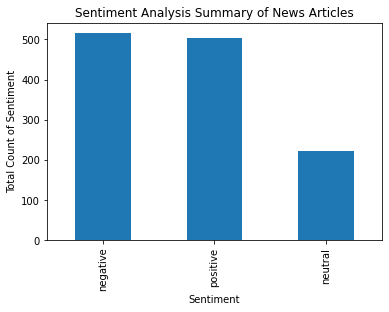

In [16]:
# Plot the sentiment
ax = data_sample['Sentiment'].value_counts().plot(kind='bar')
ax.set_title('Sentiment Analysis Summary of News Articles')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Total Count of Sentiment')

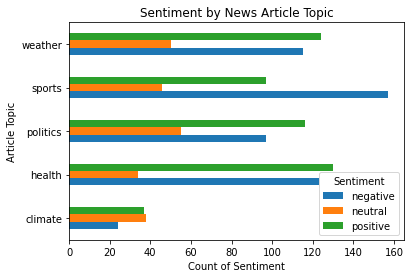

In [17]:
# Show a horizontal bar plot of sentiment by article topics
data_sample.groupby('LABEL').Sentiment.value_counts().unstack().plot.barh()
plt.xlabel("Count of Sentiment")
plt.ylabel("Article Topic")
plt.title("Sentiment by News Article Topic")
plt.show()

In [18]:
# Create a new column with tokenized words
data_sample['words'] = data_sample['clean_article'].apply(lambda x: nltk.word_tokenize(x))

In [19]:
# Validate new column in dataframe
data_sample

,LABEL,article,clean_article,Sentiment Score,Sentiment,words
3437,politics,I could hardly believe this ad in the New York...,could hardly believe ad new york times last fr...,0.0000,neutral,"[could, hardly, believe, ad, new, york, times,..."
4846,politics,Let s go for my web review for the week Japan ...,let go web review week japan goes copyright ap...,-0.2500,negative,"[let, go, web, review, week, japan, goes, copy..."
19305,weather,Google Maps will soon be making its Immersive ...,google maps soon making immersive view even be...,0.4404,positive,"[google, maps, soon, making, immersive, view, ..."
24018,weather,Geneva AFP Celeste Saulo the incoming head of ...,geneva afp celeste saulo incoming head un agen...,-0.6908,negative,"[geneva, afp, celeste, saulo, incoming, head, ..."
7552,sports,David Chapman is CEO of Marketing a national c...,david chapman ceo marketing national content m...,0.0000,neutral,"[david, chapman, ceo, marketing, national, con..."
...,...,...,...,...,...,...
9969,sports,PITTSBURGH AP Former Pittsburgh Steelers and N...,pittsburgh ap former pittsburgh steelers new y...,0.2023,positive,"[pittsburgh, ap, former, pittsburgh, steelers,..."
18279,health,The Senate President Ahmad Lawan has commissio...,senate president ahmad lawan commissioned proj...,0.4588,positive,"[senate, president, ahmad, lawan, commissioned..."
18275,health,By Michael Nevradakis Ph D The Defender The Wo...,michael nevradakis ph defender world organizat...,0.1027,positive,"[michael, nevradakis, ph, defender, world, org..."
5052,politics,Heres how in its lead story Thursday The New Y...,heres lead story thursday new york timesdescri...,-0.6908,negative,"[heres, lead, story, thursday, new, york, time..."


In [20]:
# Create a corpus for positive, negative and neutral articles
import itertools

# Positive reviews
pos_articles = data_sample[data_sample['Sentiment']=='positive']['words']
print("Total positive articles: ", len(pos_articles))
pos_words = list(itertools.chain(*pos_articles))
print("Total words in positive articles:", len(pos_words))

# Negative reviews
neg_articles = data_sample[data_sample['Sentiment']=='negative']['words']
print("Total negative articles: ", len(neg_articles))
neg_words = list(itertools.chain(*neg_articles))
print("Total words in negative articles:", len(neg_words))

# Neutral reviews
neu_articles = data_sample[data_sample['Sentiment']=='neutral']['words']
print("Total neutral articles: ", len(neu_articles))
neu_words = list(itertools.chain(*neu_articles))
print("Total words in neutral articles:", len(neu_words))

Total positive articles:  504
Total words in positive articles: 9756
Total negative articles:  516
Total words in negative articles: 11123
Total neutral articles:  223
Total words in neutral articles: 4171


In [21]:
# Create word frequency for each sentiment
import collections

# Show word frequency for positive articles
pos_wordfreq = collections.Counter(pos_words)

# Print the top 20 most frequent words in positive articles
print("Most common positive words:", pos_wordfreq.most_common(20))

# Show word frequency for negative articles
neg_wordfreq = collections.Counter(neg_words)

# Print the top 20 most frequent words in negative articles
print("Most common negative words:", neg_wordfreq.most_common(20))

# Show word frequency for neutral articles
neu_wordfreq = collections.Counter(neu_words)

# Print the top 20 most frequent words in neutral articles
print("Most common neutral words:", neu_wordfreq.most_common(20))

Most common positive words: [('news', 80), ('breaking', 56), ('new', 54), ('free', 50), ('time', 46), ('may', 41), ('one', 40), ('sign', 38), ('world', 35), ('td', 35), ('year', 34), ('li', 29), ('emails', 28), ('week', 28), ('years', 27), ('get', 25), ('good', 22), ('like', 21), ('summer', 21), ('best', 21)]
Most common negative words: [('li', 1206), ('data', 244), ('use', 242), ('ul', 242), ('services', 242), ('abuse', 242), ('track', 241), ('measure', 241), ('cookies', 240), ('deliver', 240), ('maintain', 240), ('google', 240), ('outages', 240), ('protect', 240), ('spam', 240), ('fraud', 240), ('audience', 240), ('engagement', 240), ('site', 240), ('statistics', 240)]
Most common neutral words: [('new', 29), ('powered', 28), ('finished', 28), ('speed', 24), ('liter', 23), ('six', 23), ('may', 23), ('news', 18), ('black', 17), ('v', 17), ('one', 17), ('leather', 15), ('upholstery', 14), ('time', 13), ('transmission', 12), ('four', 12), ('includes', 11), ('metallic', 11), ('paired', 1

In [22]:
# Visualize word frequency for each sentiment
import pandas as pd

# Word frequency for positive articles
pos_wf = pd.DataFrame(pos_wordfreq.most_common(20),
                                     columns=["Word", "Frequency"])
pos_wf

,Word,Frequency
0,news,80
1,breaking,56
2,new,54
3,free,50
4,time,46
5,may,41
6,one,40
7,sign,38
8,world,35
9,td,35


In [23]:
# Word frequency for negative articles
neg_wf = pd.DataFrame(neg_wordfreq.most_common(20),
                                     columns=["Word", "Frequency"])
neg_wf

,Word,Frequency
0,li,1206
1,data,244
2,use,242
3,ul,242
4,services,242
5,abuse,242
6,track,241
7,measure,241
8,cookies,240
9,deliver,240


In [24]:
# Word frequency for negative articles
neu_wf = pd.DataFrame(neu_wordfreq.most_common(20),
                                     columns=["Word", "Frequency"])
neu_wf

,Word,Frequency
0,new,29
1,powered,28
2,finished,28
3,speed,24
4,liter,23
5,six,23
6,may,23
7,news,18
8,black,17
9,v,17


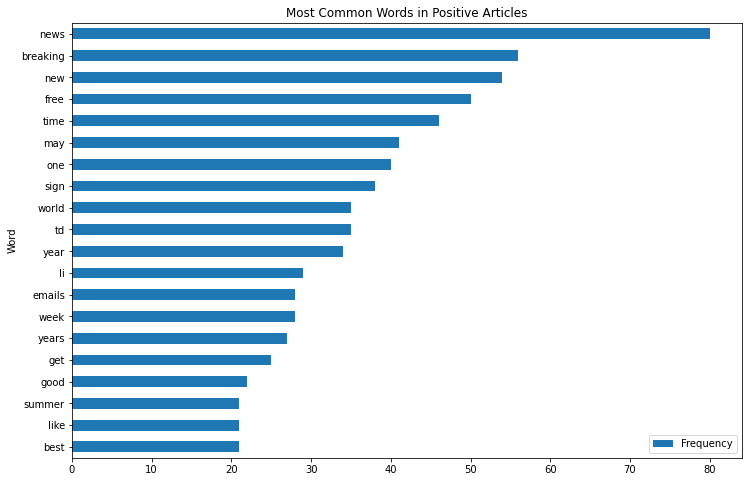

In [25]:
# Create horizontal bar graphs to visualize each sentiment
import matplotlib.pyplot as plt

# Set figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar plot for positive sentiment
pos_wf.sort_values(by='Frequency').plot.barh(x="Word", y="Frequency", ax=ax)

# Add a title to the bar plot
plt.title("Most Common Words in Positive Articles")
plt.show()

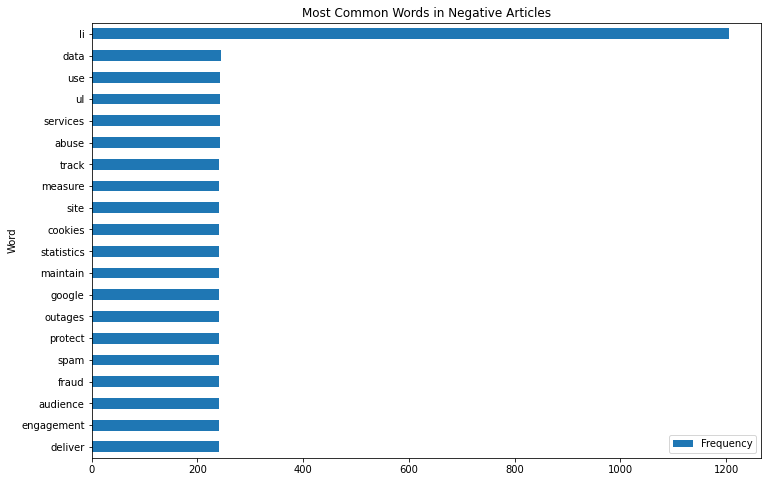

In [26]:
# Set figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar plot for negative sentiment
neg_wf.sort_values(by='Frequency').plot.barh(x="Word", y="Frequency", ax=ax)

# Add a title to the bar plot
plt.title("Most Common Words in Negative Articles")
plt.show()

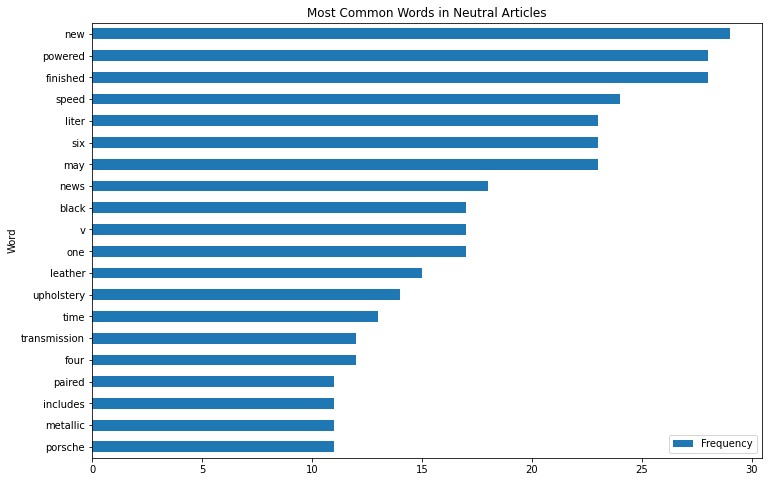

In [27]:
# Set figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar plot for negative sentiment
neu_wf.sort_values(by='Frequency').plot.barh(x="Word", y="Frequency", ax=ax)

# Add a title to the bar plot
plt.title("Most Common Words in Neutral Articles")
plt.show()

In [28]:
#Run sentiment through models
VectorizeModelCrossVal(data_sample, text_column = 'clean_article', label_column = 'Sentiment', cross_val_folds = 10)

C:\Users\nvidetti\AppData\Local\Temp\ipykernel_12872\4079261665.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label_column] = [str(row) for row in data[label_column]]
C:\Users\nvidetti\AppData\Local\Temp\ipykernel_12872\4079261665.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[text_column] = [str(row) for row in data[text_column]]
C:\Users\nvidetti\AppData\Local\Temp\ipykernel_12872\4079261665.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

--------------ACCURACY SUMMARY---------------

Multinomial Naive Bayes with Count Vectorization - 10 FOLD CROSS VALIDATION
Average Accuracy: 42.26 %
Minimum Accuracy: 36.29 %
Maximum Accuracy: 47.58 %
Confusion Matrix for Folds Where All 3 Classifications are Represented:
[[507   1   8]
 [215   0   6]
 [483   3  17]]

Multinomial Naive Bayes with Boolean Count Vectorization - 10 FOLD CROSS VALIDATION
Average Accuracy: 41.05 %
Minimum Accuracy: 33.06 %
Maximum Accuracy: 45.97 %
Confusion Matrix for Folds Where All 3 Classifications are Represented:
[[452   0  64]
 [194   0  29]
 [441   3  57]]

Multinomial Naive Bayes with TfIdf Vectorization - 10 FOLD CROSS VALIDATION
Average Accuracy: 39.11 %
Minimum Accuracy: 33.06 %
Maximum Accuracy: 46.77 %
Confusion Matrix for Folds Where All 3 Classifications are Represented:
[[388   0 127]
 [179   0  42]
 [407   0  97]]

Multinomial Naive Bayes with Boolean TfIdf Vectorization - 10 FOLD CROSS VALIDATION
Average Accuracy: 40.65 %
Minimum Accuracy